# Import libraries

In [363]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.impute import SimpleImputer
import re


# Helper Functions

## Convert each row of sq feet column to float

In [364]:
def numeric_conversion(value):
    """
    Converts each row of the dataframe column to float
    Returns NaN if no numeric characters are found.
    
    Args:
        value: The value to convert (string, int, float)
        
    Returns:
        float: Cleaned numeric value or NaN if no numbers found
    """
    try:
        # If value is already numeric, return it as float
        if isinstance(value, (int, float)):
            return float(value)
        
        # Extract all numeric characters (including decimal point)
        numbers = re.findall(r'\d*\.?\d+', str(value))
        
        # If we found numbers, convert the first one to float
        if numbers:
            num = float(numbers[0])
            if 0.0 <= num <= 100.0:  # square footage of less than 100 is as good as NaN
                return np.nan
            else:
                return num
    except:
        return np.nan


## Convert beds to float


In [365]:
def beds_conversion(value):
    try:
        # If value is already numeric, return it as float
        if value == 'Studio':
            return 0
        elif isinstance(value, (int, float)):
            return float(value)
        else:
            numbers = re.findall(r'\d*\.?\d+', str(value))
        
        # If we found numbers, convert the first one to float
        if numbers:
            num = float(numbers[0])
            return num
        else:
            return np.nan
    except:
        return np.nan


## Adjusted R2 score

Adjusted R2 score is preferred over regular R2 score because it penalizes models for adding unnecessary features and avoids overfitting. Adjusted R2 score will be always lower than regular R2 score, but a large gap indicates overfitting.

In [366]:
def adjusted_r2(y_test, y_pred, n_features):
    """Calculate adjusted R-squared."""
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

## Manually calculate AIC


In [367]:
def calculate_aic(y_test, y_pred, n_features):
    n = len(y_test)
    residuals = y_test - y_pred
    rss = np.sum(residuals ** 2)  # Residual sum of squares
    aic = n * np.log(rss/n) + 2 * (n_features + 1)  # +1 for intercept
    return aic

# EDA

In [368]:
# load the data
df = pd.read_csv('/Users/prithvishams/Documents/Bootcamp Concordia/M2P07-Regression_Project-main/canada_rent.csv')

df.head(10)

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      25771 non-null  int64  
 1   city               25771 non-null  object 
 2   province           25771 non-null  object 
 3   address            25646 non-null  object 
 4   latitude           25771 non-null  float64
 5   longitude          25771 non-null  float64
 6   lease_term         25725 non-null  object 
 7   type               25771 non-null  object 
 8   price              25771 non-null  float64
 9   beds               25639 non-null  object 
 10  baths              25637 non-null  object 
 11  sq_feet            21659 non-null  object 
 12  link               25771 non-null  object 
 13  furnishing         25771 non-null  object 
 14  availability_date  25759 non-null  object 
 15  smoking            23069 non-null  object 
 16  cats               255

I will drop the columns <i>rentfaster_id</i> and <i>link</i> because these are metadata that have no bearing on rent price. I will also drop <i>availability_date</i> because rent is not seasonal, nor depedeent on which date the apartment is available.<br>
Dropping address column because lat and long accounts for address.<br>
I am assuming smoking and pets have an impact on rent price as these factors have property insurance implications.


In [369]:
#drop columns
df = df.drop(columns=['rentfaster_id', 'link', 'availability_date','address'])

# check for missing values
df.isnull().sum()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        25771 non-null  object 
 1   province    25771 non-null  object 
 2   latitude    25771 non-null  float64
 3   longitude   25771 non-null  float64
 4   lease_term  25725 non-null  object 
 5   type        25771 non-null  object 
 6   price       25771 non-null  float64
 7   beds        25639 non-null  object 
 8   baths       25637 non-null  object 
 9   sq_feet     21659 non-null  object 
 10  furnishing  25771 non-null  object 
 11  smoking     23069 non-null  object 
 12  cats        25598 non-null  object 
 13  dogs        25598 non-null  object 
dtypes: float64(3), object(11)
memory usage: 2.8+ MB


In [370]:
df['sq_feet'] = pd.to_numeric(df['sq_feet'], errors='coerce')

df['sq_feet'].isna().sum()


4614

## Treatment of missing and problematic values

<b>address:</b> drop rows with missing values since we have 20,000 + rows to work with <br>
<b>lease term:</b> reclassify the rows such that lease term < 12 months = "short term', lease term > 12 months = "long term" and the third option is "negotiable". Thus, this feature will have 3 nominal values. <br>
<b>beds:</b> Convert to float and replace <i>none</i> and <i>studio</i> with <u>0</u>. Replace missing values with the median number of beds in the dataset.<br>
<b>baths:</b> Replace <i>none</i> with <u>0</u>. Replace missing values with the median number of baths in the dataset <br>
<b>sq_feet:</b> convert to float and replace NaN values with median number of sq feet in the dataset <br>
<b>furnishing:</b> Replace missing values with the mode of the column <br>
<b>smoking:</b> nominal values will be yes or no, with <i>Negotiable</i> being <i>yes</i> <br>
<b>cats</b>, <b>dogs:</b> missing values will be replaced with the mode of the column.<br>


In [372]:
#lease term cleanup
## replace 12 months and 6 months with Long Term and Short Term
df['lease_term'] = df['lease_term'].replace({
    '12 months':'Long Term',
    '6 months':'Short Term',
})
## replace remaining values with 'Negotiable'
df['lease_term'] = df['lease_term'].apply(lambda x: 'Negotiable' if x not in ['Long Term', 'Short Term'] else x)
#df.info()

# Beds cleanup
df['beds'] = df['beds'].apply(beds_conversion)
df['beds'].fillna(df['beds'].median(), inplace=True) # replace missing values with median number of beds in the dataset
#df.info()

#Baths cleanup
df['baths'] = df['baths'].apply(lambda x: 0 if x == 'none' else x)
df['baths'] = pd.to_numeric(df['baths'], errors='coerce')
df['baths'].fillna(df['baths'].median(), inplace=True) # replace missing values with median number of baths in the dataset
#df['baths'].info()

#sq_feet cleanup
df['sq_feet'] = df['sq_feet'].apply(numeric_conversion)
#df['sq_feet'].info()

#furnishing cleanup
df['furnishing'] = df['furnishing'].replace('Unfurnished, Negotiable', 'Negotiable')
#df['furnishing'].info()

#smoking cleanup
df['smoking'] = df['smoking'].replace({
    'Negotiable': 'Yes',
    'Smoking Allowed': 'Yes',
    'Non-Smoking': 'No',
    'Smoke Free Building':'No'
})
df['smoking'].fillna(df['smoking'].mode()[0], inplace=True) # replace missing values with the mode of the column
#df.info()

#cats cleanup
df['cats'] = df['cats'].fillna(df['cats'].mode()[0])
#df.info()

#dogs cleanup
df['dogs'] = df['dogs'].fillna(df['dogs'].mode()[0])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        25771 non-null  object 
 1   province    25771 non-null  object 
 2   latitude    25771 non-null  float64
 3   longitude   25771 non-null  float64
 4   lease_term  25771 non-null  object 
 5   type        25771 non-null  object 
 6   price       25771 non-null  float64
 7   beds        25771 non-null  float64
 8   baths       25771 non-null  float64
 9   sq_feet     21157 non-null  float64
 10  furnishing  25771 non-null  object 
 11  smoking     25771 non-null  object 
 12  cats        25771 non-null  bool   
 13  dogs        25771 non-null  bool   
dtypes: bool(2), float64(6), object(6)
memory usage: 2.4+ MB


## Visualization of correlation between numerical features and target variable

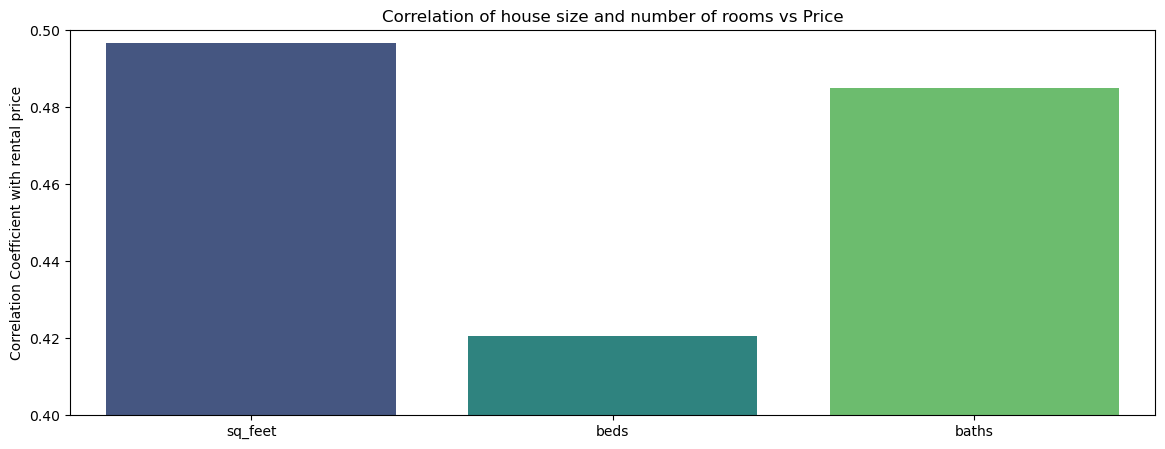

In [373]:
# isolate the numerical features to compare against rent
numerical_features = ['sq_feet', 'beds', 'baths']

#create a correlation matrix
correlation_matrix = df[numerical_features + ['price']].corr()['price'].drop('price')

#plot the correlation matrix
plt.figure(figsize=(14, 5))
sns.barplot(x=correlation_matrix.index,y=correlation_matrix.values,palette='viridis')
plt.title('Correlation of house size and number of rooms vs Price')
plt.ylabel('Correlation Coefficient with rental price')
plt.ylim(0.4,0.5)
plt.show()




In [374]:
df[numerical_features + ['price']].corr()

,sq_feet,beds,baths,price
sq_feet,1.000000,0.680959,0.673971,0.496624
beds,0.680959,1.000000,0.668731,0.420514
baths,0.673971,0.668731,1.000000,0.485014
price,0.496624,0.420514,0.485014,1.000000


The bar plot, zoomed to scale, shows that while price is mostly strongly correlated with house size, the overall correlation is low. <br>
However, there is a strong correlation between number of bedrooms, bathrooms and square footage, which is reasonable. <br>
Overall, the correlation matrix implies the categorical features and other extraneous factors may play a bigger role in determining rent price..


# Feature Engineering

## Encoding categorical features

In [375]:
#Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

#Fit and transform categorical features
categorical_features = ['city','province', 'lease_term', 'type', 'smoking', 'cats', 'dogs', 'furnishing']
encoded_features = encoder.fit_transform(df[categorical_features])

#Create a dataframe with the encoded features
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

#Concatenate the encoded features with the original dataframe
encoded_df = pd.concat([df, encoded_features_df], axis=1)

#drop the original categorical features
encoded_df.drop(columns=categorical_features, inplace=True)

#check the encoded dataframe
encoded_df.dropna(inplace=True)
encoded_df.isna().sum()


#dropped all 125 remaining missing values in order to proceed to polynomial features

latitude                  0
longitude                 0
price                     0
beds                      0
baths                     0
                         ..
smoking_Yes               0
cats_True                 0
dogs_True                 0
furnishing_Negotiable     0
furnishing_Unfurnished    0
Length: 304, dtype: int64

In [388]:
encoded_df.shape

(25089, 305)

## Converting latitude and longitude to polynomial features

Relationship between location and rent price is non-linear. Rent may exponentially higher in downtown area or affluent neighbourhoods. Moreover, latitude and longitude interact with eath other; either of them alone rarely influences the rent.

In [377]:
# Create polynomial features of lat/long
poly = PolynomialFeatures(degree=2, include_bias=False)
lat_long_poly = poly.fit_transform(encoded_df[['latitude', 'longitude']])

# Create new feature names for just the polynomial terms (excluding original features)
feature_names = ['lat^2', 'lat*long', 'long^2']  # Only the transformed features
lat_long_features = pd.DataFrame(
    lat_long_poly[:, 2:],  # Skip the first two columns (original features)
    columns=feature_names
)

# Add to original dataframe
encoded_df = pd.concat([encoded_df, lat_long_features], axis=1)
encoded_df.drop(columns=['latitude', 'longitude'], inplace=True)

## Feature Selection

In [401]:
X = encoded_df.drop(columns=['price']) #features
y = encoded_df['price'] #target variable

X.fillna(X.median(), inplace=True) #replace missing values after polynomial transformation
y.fillna(y.median(), inplace=True)


304 features is a lot, it might lead to overfitting. I will use SelectKBest to reduce the number of features using the scoring metric of mutual_info_regression to account for non-linear relationships. Running a loop to find the best k value for the selector takes too long. Due to time constraints, I selected k = 32 since the real-life data also has 32 features

In [402]:
#Initialize SelectKBest
selector = SelectKBest(score_func=mutual_info_regression, k=32)

#Fit-Transform the selector on the features
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]

# Show importance scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
})
print("Top 20 selected features:")
print(feature_scores.sort_values('Score', ascending=False).head(20))

Top 20 selected features:
                    Feature     Score
2                   sq_feet  0.957879
303                  long^2  0.394806
302                lat*long  0.375152
301                   lat^2  0.361538
0                      beds  0.344583
1                     baths  0.301735
282          type_Apartment  0.208827
41             city_Calgary  0.181248
277        province_Ontario  0.148365
298               dogs_True  0.125276
297               cats_True  0.122762
238            city_Toronto  0.115564
283           type_Basement  0.074753
79            city_Edmonton  0.072505
286              type_House  0.068976
300  furnishing_Unfurnished  0.063462
284         type_Condo Unit  0.058630
266           city_Winnipeg  0.045755
272       province_Manitoba  0.044591
278         province_Quebec  0.043831


The mutual interaction scores indicate strong relation beteen sq feet and price as seen in the previous correlation matrix.

In [403]:
X_selected_features = X[selected_features]
X_selected_features.shape #these features are now ready for model training


(25089, 32)

## Train-Test Split

In [404]:
X_train, X_test, y_train, y_test = train_test_split(X_selected_features, y, test_size=0.2, random_state=1)

#StandardScalaer is suitable for linear regression models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Model Training

We will use the following metrics to evaluate the performance of the models:
- MAE: Mean Absolute Error - indicates consistency in model performance
- MSE: Mean Squared Error
- RMSE: Root Mean Squared  - evaluates how models handle outliers
- R2 Score - indicates what percentage of the variance in the target variable is explained by the model
- Adjusted R2 Score - penalizes models for adding unnecessary features and avoids overfitting. Adjusted R2 score will be always lower than regular R2 score, but a large gap indicates overfitting.
- AIC: Akaike Information Criterion - better than r2 for penalizing overfititng. Relative difference > 2 between modelsis meaningful. Lower AIC = better model.

## Multiple Linear Regression

Let's start with a simple MLR model with no cross-validation

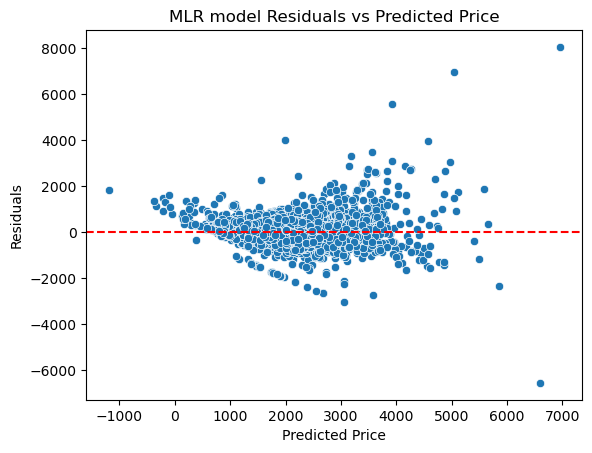

MAE: 318.79
MSE: 274690.94
RMSE: 524.11
R2 Score: 0.61
Adjusted R2 Score: 0.60
AIC: 63044.43


In [405]:
# Create model instance
mlr_model = LinearRegression()

# Train the model
mlr_model.fit(X_train, y_train)

# Make predictions
y_pred_mlr = mlr_model.predict(X_test)
residuals_mlr = y_test - y_pred_mlr

#Obtain metrics
mae_mlr = mean_absolute_error(y_test, y_pred_mlr)
mse_mlr = mean_squared_error(y_test, y_pred_mlr)
rmse_mlr = np.sqrt(mse_mlr)
r2_mlr = r2_score(y_test, y_pred_mlr)
adjusted_r2_mlr = adjusted_r2(y_test, y_pred_mlr, 100)
AIC_mlr = calculate_aic(y_test, y_pred_mlr, 100)


#plot residuals
sns.scatterplot(x=y_pred_mlr, y=residuals_mlr)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('MLR model Residuals vs Predicted Price')
plt.show()


#print metrics
print(f"MAE: {mae_mlr:.2f}")
print(f"MSE: {mse_mlr:.2f}")
print(f"RMSE: {rmse_mlr:.2f}")
print(f"R2 Score: {r2_mlr:.2f}")
print(f"Adjusted R2 Score: {adjusted_r2_mlr:.2f}")
print(f"AIC: {AIC_mlr:.2f}")



The model explains approx 60% of the variance in the target variable.<br>
Residuals are unevenly scattered around the zero residual line, indicating non-linerar relationship between features and target variable <br>
Model performs well at rents upto $4000, flies off the rails afterwards. <br>
Heteroscedasticity is present.

## RidgeCV

Since this dataset contains a lot of features, it is likely that multicollinearity is present. RidgeCV will help reduce the impact of multicollinearity by shrinking the coefficients of the features. <br>
<br>
The default cv mode of LOOCV in RidgeCV is computationally expensive, especially for our large dataset. I will use 5-fold cross validation instead.

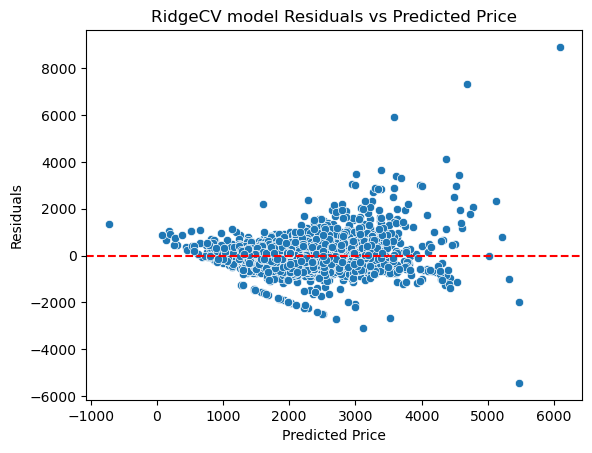

MAE: 312.73
MSE: 281788.56
RMSE: 530.84
R2 Score: 0.60
Adjusted R2 Score: 0.59
AIC: 63172.44


In [406]:
# Define alpha values to test
alphas = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 300, 500, 1000, 1500, 2000, 2500, 3000]

# Use k-fold cross validation with k = 15
kf = KFold(n_splits=15, shuffle=True, random_state=1)

# Initialize RidgeCV
ridge_cv_model = RidgeCV(alphas=alphas, cv=kf, scoring='neg_mean_absolute_error')

# Fit the model
ridge_cv_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge_cv = ridge_cv_model.predict(X_test)

#Obtain metrics
mae_ridge_cv = mean_absolute_error(y_test, y_pred_ridge_cv)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
rmse_ridge_cv = np.sqrt(mse_ridge_cv)
r2_ridge_cv = r2_score(y_test, y_pred_ridge_cv)
adjusted_r2_ridge_cv = adjusted_r2(y_test, y_pred_ridge_cv, 100)
AIC_ridge_cv = calculate_aic(y_test, y_pred_ridge_cv, 100)

#plot residuals
residuals_ridge_cv = y_test - y_pred_ridge_cv
sns.scatterplot(x=y_pred_ridge_cv, y=residuals_ridge_cv)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('RidgeCV model Residuals vs Predicted Price')
plt.show()

#plot metrics
ridge_cv_model.alpha_
print(f"MAE: {mae_ridge_cv:.2f}")
print(f"MSE: {mse_ridge_cv:.2f}")
print(f"RMSE: {rmse_ridge_cv:.2f}")
print(f"R2 Score: {r2_ridge_cv:.2f}")
print(f"Adjusted R2 Score: {adjusted_r2_ridge_cv:.2f}")
print(f"AIC: {AIC_ridge_cv:.2f}")


In [407]:
#best alpha
ridge_cv_model.alpha_

3000

RidgeCV shows almost identical performance to MLR. I would still use RidgeCV because this model is more robust to multicollinearity. We need to investigate if the metrics significantly change with other models

## LassoCV

We have 100 features in our training set. LassoCV can further refine the number of features by setting the coefficients of some features to zero. Let's see if this model shows different metrics when we specify a large range of alpha values to test

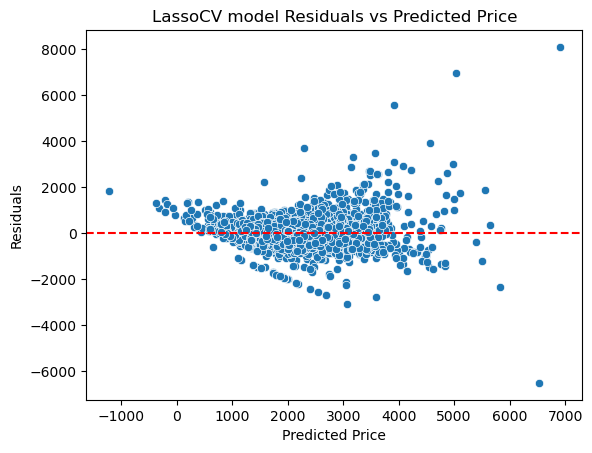

MAE: 319.10
MSE: 274501.10
RMSE: 523.93
R2 Score: 0.61
Adjusted R2 Score: 0.60
AIC: 63040.96


In [408]:
# Create instance of LassoCV
lassocv_model = LassoCV(eps=0.001,n_alphas=500,cv=10)

# Fit the model
lassocv_model.fit(X_train, y_train)

# Make predictions
y_pred_lassocv = lassocv_model.predict(X_test)

# Obtain metrics
mae_lassocv = mean_absolute_error(y_test, y_pred_lassocv)
mse_lassocv = mean_squared_error(y_test, y_pred_lassocv)
rmse_lassocv = np.sqrt(mse_lassocv)
r2_lassocv = r2_score(y_test, y_pred_lassocv)
adjusted_r2_lassocv = adjusted_r2(y_test, y_pred_lassocv, 100)
AIC_lassocv = calculate_aic(y_test, y_pred_lassocv, 100)

# Plot residuals
residuals_lassocv = y_test - y_pred_lassocv
sns.scatterplot(x=y_pred_lassocv, y=residuals_lassocv)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('LassoCV model Residuals vs Predicted Price')
plt.show()

# Plot metrics
print(f"MAE: {mae_lassocv:.2f}")
print(f"MSE: {mse_lassocv:.2f}")
print(f"RMSE: {rmse_lassocv:.2f}")
print(f"R2 Score: {r2_lassocv:.2f}")
print(f"Adjusted R2 Score: {adjusted_r2_lassocv:.2f}")
print(f"AIC: {AIC_lassocv:.2f}")

In [409]:
# best alpha lassocv
lassocv_model.alpha_

0.4258636249432121

In [410]:
lasso_coefficients = lassocv_model.coef_

non_zero_mask = lasso_coefficients != 0

non_zero_features = X_selected_features.columns[non_zero_mask]

lass_features = pd.DataFrame({
    'Feature': non_zero_features,
    'Coefficient': lasso_coefficients[non_zero_mask]
})

print(lass_features)


                      Feature  Coefficient
0                        beds   185.687186
1                       baths   178.349218
2                     sq_feet   329.893355
3                city_Calgary    64.184053
4               city_Edmonton   -89.750283
5               city_Montréal    84.789110
6                 city_Ottawa    26.716797
7                 city_Regina     5.223565
8                city_Toronto   255.335040
9               city_Winnipeg    43.096359
10  province_British Columbia   104.238248
11          province_Manitoba  -114.572036
12           province_Ontario    35.745628
13            province_Quebec   -23.493102
14      province_Saskatchewan   -62.487734
15      lease_term_Negotiable    26.514082
16      lease_term_Short Term    55.871980
17             type_Apartment   439.458038
18              type_Basement    98.108919
19            type_Condo Unit   260.842880
20                type_Duplex    45.925924
21                 type_House   105.911682
22         

The LassoCV model selected 29 features out of 32. This implies most of the 32 features selected out of the 304 features are important <br>
Model does slightly better than RidgeCV but for all practical purposes, all the 3 models perform similarly so far.

## ElasticNetCV

MAE: 319.10
MSE: 274501.10
RMSE: 523.93
R2 Score: 0.61
Adjusted R2 Score: 0.60
AIC: 63040.96


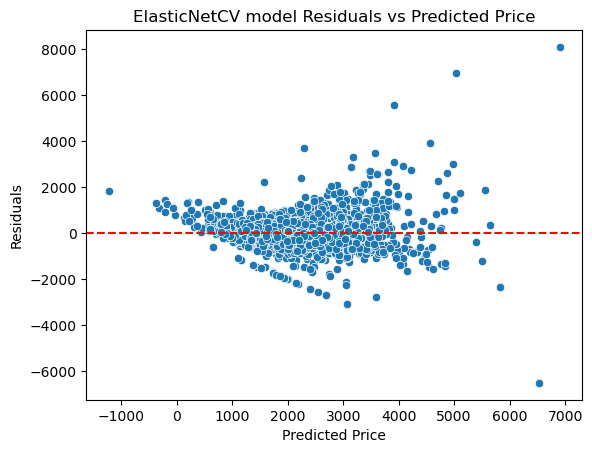

In [411]:
#list of l1 ratios to test
alphas = [0.1,0.2,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.92,0.95,0.99,1]
# Create instance of ElasticNetCV
elasticnet_model = ElasticNetCV(l1_ratio=alphas,eps=0.001,n_alphas=500,max_iter=10000)

# Fit the model
elasticnet_model.fit(X_train, y_train)

# Make predictions
y_pred_elasticnet = elasticnet_model.predict(X_test)

#Obtain metrics
mae_elasticnet = mean_absolute_error(y_test, y_pred_elasticnet)
mse_elasticnet = mean_squared_error(y_test, y_pred_elasticnet)
rmse_elasticnet = np.sqrt(mse_elasticnet)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)
adjusted_r2_elasticnet = adjusted_r2(y_test, y_pred_elasticnet, 100)
AIC_elasticnet = calculate_aic(y_test, y_pred_elasticnet, 100)

#plot residuals
residuals_elasticnet = y_test - y_pred_elasticnet
sns.scatterplot(x=y_pred_elasticnet, y=residuals_elasticnet)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('ElasticNetCV model Residuals vs Predicted Price')

#plot metrics
print(f"MAE: {mae_elasticnet:.2f}")
print(f"MSE: {mse_elasticnet:.2f}")
print(f"RMSE: {rmse_elasticnet:.2f}")
print(f"R2 Score: {r2_elasticnet:.2f}")
print(f"Adjusted R2 Score: {adjusted_r2_elasticnet:.2f}")
print(f"AIC: {AIC_elasticnet:.2f}")

With the present set of features, all the different models perform similarly and can be used interchangeably. <br>

I will now exclude latitude and longitude from the feature set and see if there is any change in the metrics.

# Model Training without latitude and longitude

In [412]:
# Create a new dataframe with encoded features excluding latitude-longitude
enc_df_2 = pd.concat([df,encoded_features_df],axis=1)
enc_df_2.drop(columns=categorical_features,inplace=True) #drop categorical features
enc_df_2.drop(columns=['latitude','longitude'],inplace=True) #drop latitude and longitude

enc_df_2.isna().sum()

price                        0
beds                         0
baths                        0
sq_feet                   4614
city_Airdrie                 0
                          ... 
smoking_Yes                  0
cats_True                    0
dogs_True                    0
furnishing_Negotiable        0
furnishing_Unfurnished       0
Length: 302, dtype: int64

In [418]:
#create instace of SimpleImputer
imputer_sqft = SimpleImputer(strategy='median')

#fit and transform the imputer on the sq_feet column of dataframe
enc_df_2['sq_feet'] = imputer_sqft.fit_transform(enc_df_2[['sq_feet']])

#Separate features and target variable
X_enc_2 = enc_df_2.drop(columns=['price'])
y_enc_2 = enc_df_2['price']

(X_enc_2.shape, y_enc_2.shape)






((25771, 301), (25771,))

Number of features is 3 less than the previous feature set including lat and longitude. We will use SelectKBest to select the best 29 features to match the real life data excluding lat and long

In [441]:
# Create new instance of SelectKBest
selector_2 = SelectKBest(score_func=mutual_info_regression, k=29)

#Fit-Transform the selector on the features
X_selected_2 = selector_2.fit_transform(X_enc_2, y_enc_2)

# Get selected feature names
selected_features_2 = X_enc_2.columns[selector_2.get_support()]

# Show importance scores
feature_scores_2 = pd.DataFrame({
    'Feature': X_enc_2.columns,
    'Score': selector_2.scores_
})
print("Top 20 selected features:")
print(feature_scores_2.sort_values('Score', ascending=False).head(20))


Top 20 selected features:
                    Feature     Score
2                   sq_feet  0.644586
1                     baths  0.269981
0                      beds  0.261235
282          type_Apartment  0.184172
41             city_Calgary  0.144641
277        province_Ontario  0.120484
238            city_Toronto  0.097730
298               dogs_True  0.092762
297               cats_True  0.086901
283           type_Basement  0.081705
292      type_Room For Rent  0.078977
79            city_Edmonton  0.069289
286              type_House  0.068409
300  furnishing_Unfurnished  0.058534
284         type_Condo Unit  0.049373
272       province_Manitoba  0.042140
266           city_Winnipeg  0.034584
279   province_Saskatchewan  0.034232
280   lease_term_Negotiable  0.034188
278         province_Quebec  0.033930


In [442]:
# Train-Test Split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_selected_2, y_enc_2, test_size=0.2, random_state=1)

#StandardScaler
scaler_2 = StandardScaler()
X_train_2 = scaler_2.fit_transform(X_train_2)
X_test_2 = scaler_2.transform(X_test_2)

## Multiple Linear Regression without latitude and longitude

MAE: 375.74
MSE: 400914.70
RMSE: 633.18
R2 Score: 0.54
Adjusted R2 Score: 0.53
AIC: 66709.25


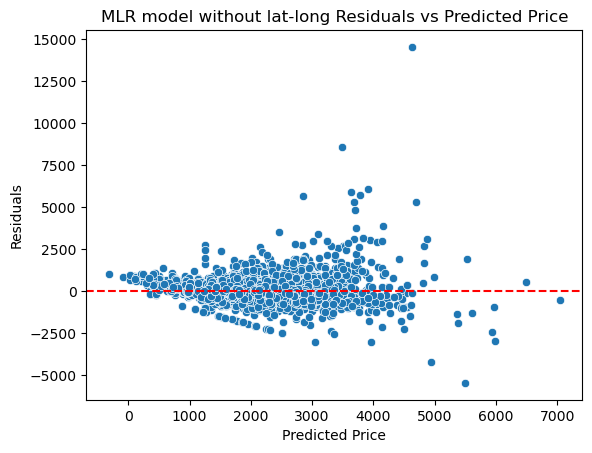

In [443]:
#Create model instance
mlr_model_2 = LinearRegression()

#Train the model
mlr_model_2.fit(X_train_2, y_train_2)

#Make predictions
y_pred_mlr_2 = mlr_model_2.predict(X_test_2)

#Obtain metrics
mae_mlr_2 = mean_absolute_error(y_test_2, y_pred_mlr_2)
mse_mlr_2 = mean_squared_error(y_test_2, y_pred_mlr_2)
rmse_mlr_2 = np.sqrt(mse_mlr_2)
r2_mlr_2 = r2_score(y_test_2, y_pred_mlr_2)
adjusted_r2_mlr_2 = adjusted_r2(y_test_2, y_pred_mlr_2, 100)
AIC_mlr_2 = calculate_aic(y_test_2, y_pred_mlr_2, 100)

#plot residuals
residuals_mlr_2 = y_test_2 - y_pred_mlr_2
sns.scatterplot(x=y_pred_mlr_2, y=residuals_mlr_2)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('MLR model without lat-long Residuals vs Predicted Price')

#print metrics
print(f"MAE: {mae_mlr_2:.2f}")
print(f"MSE: {mse_mlr_2:.2f}")
print(f"RMSE: {rmse_mlr_2:.2f}")
print(f"R2 Score: {r2_mlr_2:.2f}")
print(f"Adjusted R2 Score: {adjusted_r2_mlr_2:.2f}")
print(f"AIC: {AIC_mlr_2:.2f}")


The metrics have gotten worse, but the variance of the residuals is lower and more homoscedastic. <br>
Outliers have decreased, prediction accuracy has increased at higher rental prices. <br>
<br>
Let's compare ElasticNerCV and LassoCV with this new feature set.

## LassoCV without latitude and longitude

MAE: 375.70
MSE: 401264.63
RMSE: 633.45
R2 Score: 0.54
Adjusted R2 Score: 0.53
AIC: 66713.75


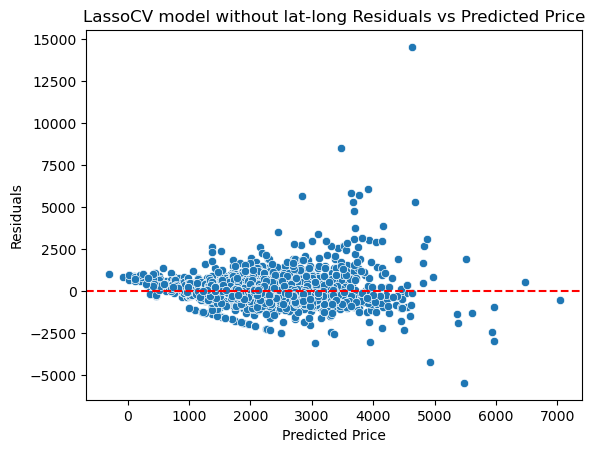

In [444]:
#create the model
lassocv_model_2 = LassoCV(eps=0.001,n_alphas=500,cv=10)

#Train the model
lassocv_model_2.fit(X_train_2, y_train_2)

#Make predictions
y_pred_lassocv_2 = lassocv_model_2.predict(X_test_2)

#obtain metrics
mae_lassocv_2 = mean_absolute_error(y_test_2, y_pred_lassocv_2)
mse_lassocv_2 = mean_squared_error(y_test_2, y_pred_lassocv_2)
rmse_lassocv_2 = np.sqrt(mse_lassocv_2)
r2_lassocv_2 = r2_score(y_test_2, y_pred_lassocv_2)
adjusted_r2_lassocv_2 = adjusted_r2(y_test_2, y_pred_lassocv_2, 100)
AIC_lassocv_2 = calculate_aic(y_test_2, y_pred_lassocv_2, 100)

#plot residuals
residuals_lassocv_2 = y_test_2 - y_pred_lassocv_2
sns.scatterplot(x=y_pred_lassocv_2, y=residuals_lassocv_2)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('LassoCV model without lat-long Residuals vs Predicted Price')

#plot metrics
print(f"MAE: {mae_lassocv_2:.2f}")
print(f"MSE: {mse_lassocv_2:.2f}")
print(f"RMSE: {rmse_lassocv_2:.2f}")
print(f"R2 Score: {r2_lassocv_2:.2f}")
print(f"Adjusted R2 Score: {adjusted_r2_lassocv_2:.2f}")
print(f"AIC: {AIC_lassocv_2:.2f}")

## ElasticNetCV without latitude and longitude

MAE: 375.70
MSE: 401264.63
RMSE: 633.45
R2 Score: 0.54
Adjusted R2 Score: 0.53
AIC: 66713.75


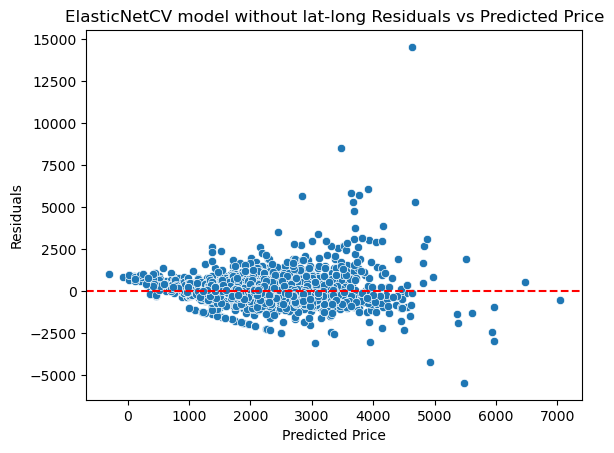

In [445]:
# Create new instance of ElasticNetCV
elasticnet_model_2 = ElasticNetCV(l1_ratio=alphas,eps=0.001,n_alphas=500,max_iter=10000)

# Fit the model
elasticnet_model_2.fit(X_train_2, y_train_2)

# Make predictions
y_pred_elasticnet_2 = elasticnet_model_2.predict(X_test_2)

# Obtain metrics
mae_elasticnet_2 = mean_absolute_error(y_test_2, y_pred_elasticnet_2)
mse_elasticnet_2 = mean_squared_error(y_test_2, y_pred_elasticnet_2)
rmse_elasticnet_2 = np.sqrt(mse_elasticnet_2)
r2_elasticnet_2 = r2_score(y_test_2, y_pred_elasticnet_2)
adjusted_r2_elasticnet_2 = adjusted_r2(y_test_2, y_pred_elasticnet_2, 100)
AIC_elasticnet_2 = calculate_aic(y_test_2, y_pred_elasticnet_2, 100)

#plot residuals
residuals_elasticnet_2 = y_test_2 - y_pred_elasticnet_2
sns.scatterplot(x=y_pred_elasticnet_2, y=residuals_elasticnet_2)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('ElasticNetCV model without lat-long Residuals vs Predicted Price')

#plot metrics
print(f"MAE: {mae_elasticnet_2:.2f}")
print(f"MSE: {mse_elasticnet_2:.2f}")
print(f"RMSE: {rmse_elasticnet_2:.2f}")
print(f"R2 Score: {r2_elasticnet_2:.2f}")
print(f"Adjusted R2 Score: {adjusted_r2_elasticnet_2:.2f}")
print(f"AIC: {AIC_elasticnet_2:.2f}")


We observe a similar phenomenon where the different cross-validation models perform similarly on the same feature set. <br>
Excluding latidue and longitude has improved the residual plot, but degraded the metrics. <br>

Since the models are almost identical on the same feature set, I choose LassoCV to compare the predicted prices with real life data including and excluding latitude and longitude..

# Train model on entire dataset

In [446]:
# Create instance of LassoCV
lassocv_model_real_poly = LassoCV(eps=0.001,n_alphas=500,cv=10)
lassocv_model_real_no_poly = LassoCV(eps=0.001,n_alphas=500,cv=10)


# Fit the model
lassocv_model_real_poly=lassocv_model_real.fit(X_selected,y) #with poly features
lassocv_model_real_no_poly = lassocv_model_real.fit(X_selected_2,y_enc_2) #without poly features



/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2018656.8425312042, tolerance: 1554366.4361985242
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678586.9746704102, tolerance: 1554366.4361985242
  model = cd_fast.enet_coordinate_descent_gram(


In [434]:
(X_selected.shape, X_selected_2.shape)

((25089, 32), (25771, 32))

# Real-life data

## Load and preprocess the data

In [435]:
#Load the data
df_real = pd.read_csv('/Users/prithvishams/Documents/Bootcamp Concordia/M2P07-Regression_Project-main/actual_rent.csv')

# Separate features and target variable
X_real = df_real.drop(columns=['price'])
y_real = df_real['price']

# Create instance of OneHotEncoder
encoder_real = OneHotEncoder(drop = 'first',sparse_output=False)

#Fit and transform categorical features
categorical_features_real = ['city','province', 'lease_term', 'type', 'smoking', 'cats', 'dogs', 'furnishing']
encoded_features_real = encoder_real.fit_transform(X_real[categorical_features_real])

# Create a new dataframe with encoded features
encoded_features_real_df = pd.DataFrame(encoded_features_real,columns=encoder_real.get_feature_names_out(categorical_features_real))

# Drop the original categorical features
X_real_encoded = X_real.drop(columns=categorical_features_real)

# Concatenate the encoded features with the numerical features
X_real_encoded = pd.concat([X_real_encoded,encoded_features_real_df],axis=1)

#Create a version of the encoded features dataframe without lat-long
X_real_encoded.drop(columns=['latitude','longitude'],inplace=True)


In [436]:
# Convert latitude and longitude
poly_2 = PolynomialFeatures(degree=2,include_bias=False)
lat_long_poly_2 = poly_2.fit_transform(X_real[['latitude','longitude']])

#Create new feature names for just the polynomial terms excluding original features
feature_names_2 = ['lat^2', 'lat*long', 'long^2']  # Only the transformed features

#Create dataframe with polynomial terms
lat_long_poly_2_df = pd.DataFrame(lat_long_poly_2[:,2:],columns=feature_names_2) #skip the first two columns (original features)

#Concatenate the polynomial terms with the original features
X_real_encoded_poly = pd.concat([X_real_encoded,lat_long_poly_2_df],axis=1)




In [437]:
#Scale real-life features
scaler_real = StandardScaler()
X_real_encoded_scaled = scaler_real.fit_transform(X_real_encoded) #without lat-long
X_real_encoded_poly_scaled = scaler_real.fit_transform(X_real_encoded_poly) #with lat-long




## Prediction of real-life data including latitude and longitude

In [439]:
predicted_real_poly = lassocv_model_real_poly.predict(X_real_encoded_poly_scaled)
residuals_real_poly = y_real - predicted_real_poly

results_real_poly = pd.DataFrame({
    'Province': X_real['province'],
    'City': X_real['city'],
    'Actual': y_real,
    'Predicted': predicted_real_poly,
    'Residual': residuals_real_poly
})

results_real_poly

,Province,City,Actual,Predicted,Residual
0,Alberta,Airdrie,1750,1354.368141,395.631859
1,British Columbia,Vancouver,4795,1354.465066,3440.534934
2,Manitoba,Winnipeg,3590,1356.902050,2233.097950
3,New Brunswick,Dieppe,2300,1355.326318,944.673682
4,Newfoundland and Labrador,St. John's,1015,1353.765818,-338.765818
5,Nova Scotia,Halifax,5400,1354.278139,4045.721861
6,Ontario,Mississauga,3650,1355.655865,2294.344135
7,Quebec,Montr√©al,2045,1354.271215,690.728785
8,Saskatchewan,Lloydminster,1558,1354.352910,203.647090


## Prediction of real-life data excluding latitude and longitude

In [447]:
predicted_real_no_poly = lassocv_model_real_no_poly.predict(X_real_encoded_scaled)
residuals_real_no_poly = y_real - predicted_real_no_poly

results_real_no_poly = pd.DataFrame({
    'Province': X_real['province'],
    'City': X_real['city'],
    'Actual': y_real,
    'Predicted': predicted_real_no_poly,
    'Residual': residuals_real_no_poly
})

results_real_no_poly

,Province,City,Actual,Predicted,Residual
0,Alberta,Airdrie,1750,1354.368141,395.631859
1,British Columbia,Vancouver,4795,1354.465066,3440.534934
2,Manitoba,Winnipeg,3590,1356.902050,2233.097950
3,New Brunswick,Dieppe,2300,1355.326318,944.673682
4,Newfoundland and Labrador,St. John's,1015,1353.765818,-338.765818
5,Nova Scotia,Halifax,5400,1354.278139,4045.721861
6,Ontario,Mississauga,3650,1355.655865,2294.344135
7,Quebec,Montr√©al,2045,1354.271215,690.728785
8,Saskatchewan,Lloydminster,1558,1354.352910,203.647090


In my judgement, residuals of < 500 are acceptable.<br>
Out of 9 real-life data points, only 3 points or 33% of the predictions are acceptable per my standard. <br>

No difference in the residuals with or without the latitude and longitude features.

The model performed significantly better on the training data, but the residuals are significantly higher on the test data. This implies overfitting, which could be attributable to the high number of features in the model even after feature selection. <br>

Moreover, the model predicted the price based on only 9 data points from the real-life feature set, which is not enough to make any significant conclusions. It'd be interesting to see how the model performs when the number of data points is comparable to the training set.